In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import re

title = 'woplus'
path = '../../sources/data'

In [3]:
df_net = pd.read_table('{}/dataset_2015_filter_net.txt'.format(path), sep='|')
df_net_piv = df_net.pivot(index='imsi', columns='mon')
df_net_piv.columns = ['net01','net02','net03','net04','net05','net06','net07','net08','net09','net10','net11','net12']

df_age = pd.read_table('{}/dataset_2015_filter_age.txt'.format(path), sep='|')
df_age_piv = df_age.pivot(index='imsi', columns='mon')
df_age_piv.columns = ['age01','age02','age03','age04','age05','age06','age07','age08','age09','age10','age11','age12']

df_sex = pd.read_table('{}/dataset_2015_filter_sex.txt'.format(path), sep='|')
df_sex_piv = df_sex.pivot(index='imsi', columns='mon')
df_sex_piv.columns = ['sex01','sex02','sex03','sex04','sex05','sex06','sex07','sex08','sex09','sex10','sex11','sex12']

df_arpu = pd.read_table('{}/dataset_2015_filter_arpu.txt'.format(path), sep='|')
df_arpu_piv = df_arpu.pivot(index='imsi', columns='mon')
df_arpu_piv.columns = ['arpu01','arpu02','arpu03','arpu04','arpu05','arpu06','arpu07','arpu08','arpu09','arpu10','arpu11','arpu12']

df_stream = pd.read_table('{}/dataset_2015_filter_stream.txt'.format(path), sep='|')
df_stream_piv = df_stream.pivot(index='imsi', columns='mon')
df_stream_piv.columns = ['stream01','stream02','stream03','stream04','stream05','stream06','stream07','stream08','stream09','stream10','stream11','stream12']

df_sms = pd.read_table('{}/dataset_2015_filter_sms.txt'.format(path), sep='|')
df_sms_piv = df_sms.pivot(index='imsi', columns='mon')
df_sms_piv.columns = ['sms01','sms02','sms03','sms04','sms05','sms06','sms07','sms08','sms09','sms10','sms11','sms12']

df_talklen = pd.read_table('{}/dataset_2015_filter_talklen.txt'.format(path), sep='|')
df_talklen_piv = df_talklen.pivot(index='imsi', columns='mon')
df_talklen_piv.columns = ['talklen01','talklen02','talklen03','talklen04','talklen05','talklen06','talklen07','talklen08','talklen09','talklen10','talklen11','talklen12']

df_me = pd.read_table('{}/dataset_2015_filter_me.txt'.format(path), sep='|')
df_me_piv = df_me.pivot(index='imsi', columns='mon')
df_me_piv.columns = ['brand01','brand02','brand03','brand04','brand05','brand06','brand07','brand08','brand09','brand10','brand11','brand12',\
                     'type01','type02','type03','type04','type05','type06','type07','type08','type09','type10','type11','type12']

## Data Summary

In [4]:
def ValueCounts(das, nhead=5):
    tmp = pd.value_counts(das).reset_index().rename_axis({'index': das.name}, axis=1)
    value = pd.DataFrame(['Value {}'.format(x+1) for x in np.arange(nhead)], index=np.arange(nhead)).join(tmp.iloc[:, 0], how='left').set_index(0).T
    freq = pd.DataFrame(['Freq {}'.format(x+1) for x in np.arange(nhead)], index=np.arange(nhead)).join(tmp.iloc[:, 1], how='left').set_index(0).T
    nnull = das.isnull().sum()
    freqother = pd.DataFrame({das.name: [das.shape[0] - nnull - np.nansum(freq.values), nnull]}, index=['Freq Others','Freq NA']).T
    op = pd.concat([value, freq, freqother], axis=1)
    return op

def Summary(da):
    op = pd.concat([pd.DataFrame({'type':da.dtypes, 'nnullCount':da.notnull().sum(axis=0)}), da.describe().T.iloc[:, 1:],
          pd.concat(map(lambda i: ValueCounts(da.loc[:,i]), da.columns))], axis=1).loc[da.columns]
    op.index.name='columns'
    return op

## Category Feature's Bin with OHC

In [5]:
def Cat_to_bin(das, a = 0.01):
    '''Transfrom a categorical column to onehotencoding'''
    tmp = pd.value_counts(das)/das.shape[0]
    cat = list(tmp.index[tmp > a])
    cat.sort()   # 改良：使用cat前对cat进行一次排序，保证顺序一致
    enc = OneHotEncoder(n_values = len(cat)+1, sparse = False)
    xbin = enc.fit_transform(np.transpose(
            [das.astype("category").cat.set_categories(cat).cat.rename_categories(1+np.arange(len(cat))).astype("float").fillna(0).values]))[:,1:]     
    dabin = pd.DataFrame(xbin, columns = ["{}_{}".format(das.name[:-2], x) for x in cat], index = das.index)    # origin
    # dabin = pd.DataFrame(xbin, columns = ["{}_{}".format(das.name, x) for x in (1+np.arange(len(cat)))], index = das.index) 
    if(tmp[tmp <= a].sum() > a):
        dabin = pd.concat([dabin, pd.DataFrame({"{}_Others".format(das.name[:-2]):das.notnull()-dabin.sum(axis = 1)})], axis = 1)
    if(dabin.shape[1] == 2):
        dabin = pd.DataFrame({das.name[:-2]: xbin[:,0]}, index = das.index)
    return(dabin)

def CattoBin(da, a = 0.01):
    op = pd.concat(map(lambda i: Cat_to_bin(da.loc[:, i], a), da.columns), axis=1)
    return op

## Numerical Feature's Standardalization with StandardScaler

In [6]:
def SSTraining(da):
    ss = StandardScaler().fit(da)
    # ss.mean_
    # ss.scale_
    newColumns = []
    for col in da.columns:
        newColumns.append(col[:-2])
    op = pd.DataFrame(ss.transform(da), index=da.index, columns=newColumns)
    return op, ss

## Label's Generation

In [7]:
def isChangingStrict(dl):
    return len(np.unique(dl))

def labelGenerate(df, Mon1, Mon2):
    df_phone = df.loc[:,['brand'+Mon1,'type'+Mon1,'brand'+Mon2,'type'+Mon2]]
    df_phone_label_strict = df_phone.apply(isChangingStrict, axis=1)
    df_phone_label_strict[df_phone_label_strict < 3] = 0
    df_phone_label_strict[df_phone_label_strict >=3] = 1
    return pd.DataFrame(df_phone_label_strict, columns=['Flag'])

## Feature's Generation

In [8]:
def selMonAndGenFeat(mon):
    featList = df_net_piv.columns.tolist()
    df_net_piv_sel = df_net_piv.loc[:, map(lambda i: re.findall('\d{2}',featList[i])[0] == mon, np.arange(len(featList)))]
    
    featList = df_age_piv.columns.tolist()
    df_age_piv_sel = df_age_piv.loc[:, map(lambda i: re.findall('\d{2}',featList[i])[0] == mon, np.arange(len(featList)))]
    
    featList = df_sex_piv.columns.tolist()
    df_sex_piv_sel = df_sex_piv.loc[:, map(lambda i: re.findall('\d{2}',featList[i])[0] == mon, np.arange(len(featList)))]
    
    featList = df_arpu_piv.columns.tolist()
    df_arpu_piv_sel = df_arpu_piv.loc[:, map(lambda i: re.findall('\d{2}',featList[i])[0] == mon, np.arange(len(featList)))]
    
    featList = df_stream_piv.columns.tolist()
    df_stream_piv_sel = df_stream_piv.loc[:, map(lambda i: re.findall('\d{2}',featList[i])[0] == mon, np.arange(len(featList)))]
    
    featList = df_sms_piv.columns.tolist()
    df_sms_piv_sel = df_sms_piv.loc[:, map(lambda i: re.findall('\d{2}',featList[i])[0] == mon, np.arange(len(featList)))]
    
    featList = df_talklen_piv.columns.tolist()
    df_talklen_piv_sel = df_talklen_piv.loc[:, map(lambda i: re.findall('\d{2}',featList[i])[0] == mon, np.arange(len(featList)))]
    
    return df_net_piv_sel, df_age_piv_sel, df_sex_piv_sel, df_arpu_piv_sel, df_stream_piv_sel, df_sms_piv_sel, df_talklen_piv_sel

def featGenerate(mon):
    df_net_piv_sel, df_age_piv_sel, df_sex_piv_sel, df_arpu_piv_sel, \
    df_stream_piv_sel, df_sms_piv_sel, df_talklen_piv_sel = selMonAndGenFeat(mon)
    
    # deal with Category Features
    net_catbin = CattoBin(df_net_piv_sel)
    age_catbin = CattoBin(df_age_piv_sel)
    sex_catbin = CattoBin(df_sex_piv_sel)
    arpu_catbin = CattoBin(df_arpu_piv_sel)
    stream_catbin = CattoBin(df_stream_piv_sel)
    
    # deal with Numerical Features
    sms_ss, sscaler_sms = SSTraining(df_sms_piv_sel)
    talklen_ss, sscaler_talklen = SSTraining(df_talklen_piv_sel)
    
    # concat
    df_features = pd.concat([net_catbin, age_catbin, sex_catbin, arpu_catbin, stream_catbin, sms_ss, talklen_ss], axis=1)
    return df_features

## Generate TrainSet

In [9]:
# comment: mon is string
def genTrainSet(mon1, mon2):
    tsFeat = featGenerate(mon1)
    tsLabel = labelGenerate(df_me_piv, mon1, mon2)
    op = pd.concat([tsFeat, tsLabel], axis=1)
    return op

In [10]:
df_train_09 = genTrainSet('09', '10')
df_train_10 = genTrainSet('10', '11')
df_train_f = pd.concat([df_train_09, df_train_10], axis=0, ignore_index=True)
df_train_f.head()

,net,age_17岁以下,age_18-22,age_23-25,age_26-29,age_30-39,age_40-49,age_50-59,age_60以上,sex_不详,...,arpu_250-299,arpu_300及以上,arpu_50-99,stream_0-499,stream_1000-1499,stream_500-999,stream_Others,sms,talklen,Flag
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.127896,0.487078,0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.243601,-0.329402,0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.260130,-0.541977,0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.227071,-0.392208,0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.260130,-0.561302,0


In [11]:
m, n = np.shape(df_train_f)
X = df_train_f.iloc[:, :(n-1)].values
y = df_train_f.iloc[:, -1].values

## Training

In [44]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# np.shape(X_train)
# np.shape(X_test)

In [14]:
# BaseLine by LogisticRegression
LR = LogisticRegression()
LR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
# 1. 理解coef_和intercept_
# LR.coef_
# LR.intercept_
print X_train * np.mat(LR.coef_).T + LR.intercept_
print '\n'

# 2. 理解decision_function
# decision_function 实际上就是wTx+b
# np.shape(X_train)
# np.shape(LR.decision_function(X_train))
print LR.decision_function(X_train)
# decision_function 大于0 y_proba > 0.5 正例

# 3. predict与predict_proba
# predict函数源码原理
# a.计算decision_function scores = LR.decision_function(X_train)
# b.

[[-1.21534622]
 [-1.76453161]
 [-1.41870149]
 ..., 
 [-1.28813755]
 [-1.34659094]
 [-1.32841887]]


[-1.21534622 -1.76453161 -1.41870149 ..., -1.28813755 -1.34659094
 -1.32841887]


In [32]:
np.sum(LR.decision_function(X_train) > 0)

0

In [31]:
LR.classes_

array([0, 1])

In [48]:
yDF = LR.decision_function(X_train)
yHat = LR.predict(X_train)
yScore = LR.predict_proba(X_train)
y_testHat = LR.predict(X_test)
y_testScore = LR.predict_proba(X_test)

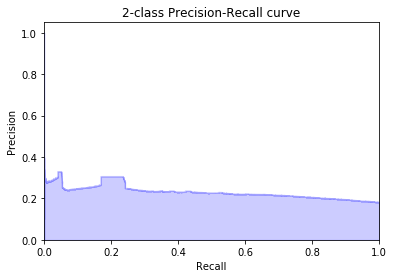

In [41]:
# pr-curve
# Note: this implementation is restricted to the binary classification task.
# Note: Parameter probas_pred can be Estimated probabilities or decision function.

precision, recall, thresholds = precision_recall_curve(y_train, yDF)
# precision_recall_curve(y_train, yScore[:, 1])
    
import matplotlib.pyplot as plt
%matplotlib inline

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')

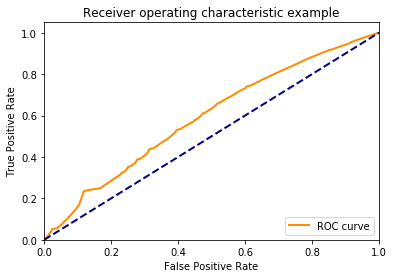

In [54]:
# roc_curve & auc
# Compute Receiver operating characteristic (ROC)
# Note: this implementation is restricted to the binary classification task.
# If labels are not binary, pos_label should be explicitly given.
fpr, tpr, thresholds = roc_curve(y_train, yScore[:,1])
auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [38]:

print u'训练集准确度：%.5f' % (np.mean(yHat == y_train))
print u'训练集AUC：%.5f'% roc_auc_score(y_train, yScore[:,1])
print classification_report(y_train, yHat)

print u'验证集准确度：%.2f' % (np.mean(y_testHat == y_test)) 
print u'验证集AUC：%.5f'% roc_auc_score(y_test, y_testScore[:,1])
print classification_report(y_test, y_testHat)

训练集准确度：0.81939
训练集AUC：0.59054
             precision    recall  f1-score   support

          0       0.82      1.00      0.90    413775
          1       0.00      0.00      0.00     91202

avg / total       0.67      0.82      0.74    504977

验证集准确度：0.82
验证集AUC：0.58893
             precision    recall  f1-score   support

          0       0.82      1.00      0.90    176951
          1       0.00      0.00      0.00     39468

avg / total       0.67      0.82      0.74    216419



/Users/fanghan/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1]:
yHat

NameError: name 'yHat' is not defined

## Generate TestSet

In [109]:
df_train_11 = genTrainSet('11', '12')
df_test_f = df_train_11
m, n = np.shape(df_test_f)
testX = df_test_f.iloc[:, :(n-1)].values
testy = df_test_f.iloc[:, -1].values

In [111]:
testyHat = LR.predict(testX)
testyScore = LR.predict_proba(testX)
print u'测试集准确度：%.2f' % (np.mean(testyHat == testy)) 
print u'测试集AUC：%.5f'% roc_auc_score(testy, testyScore[:,1])
print classification_report(testy, testyHat)

测试集准确度：0.74
测试集AUC：0.60646
             precision    recall  f1-score   support

          0       0.74      1.00      0.85    267431
          1       0.00      0.00      0.00     93267

avg / total       0.55      0.74      0.63    360698

